# Métricas de Agrupamiento (K-means y DBSCAN) (Core)
 **Descripción:**

En esta actividad, se utilizarán los algoritmos K-means y DBSCAN para agrupar datos del dataset «Credit Card Data» disponible en Kaggle. El objetivo es aplicar ambas técnicas de clustering y compararlas utilizando métricas como el «silhouette score» y el «calinski-harabasz index» para evaluar la calidad de los clusters obtenidos.

Enlace al dataset: https://www.kaggle.com/arjunbhasin2013/ccdata



## Objetivo:

El objetivo es comparar la efectividad de K-means y DBSCAN en el dataset seleccionado, evaluando la cohesión e intersección de los clusters obtenidos mediante métricas de evaluación. Se espera que los estudiantes comprendan las diferencias entre ambos algoritmos y cómo usar las métricas adecuadas para elegir el mejor modelo de clustering.




In [1]:
# Agregar la carpeta 'src' al sys.path
import sys
import os

# Buscar 'src' automáticamente sin depender del nombre del proyecto
current_dir = os.getcwd()  # Directorio actual
while not os.path.exists(os.path.join(current_dir, "src")):
    current_dir = os.path.dirname(current_dir)  # Subir un nivel
    if current_dir == "/":  # Evitar bucles infinitos
        raise FileNotFoundError("No se encontró la carpeta 'src'. Verifica la estructura.")

src_path = os.path.join(current_dir, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from utils import cargar_datos_pd
from utils import dimensiones
from utils import ver_resumen_nulos
from utils import identificar_atipicos_IQR
from utils import ver_diccionario
from utils import imprimir_bigotes
from utils import plot_varianza
from utils import filtrar_columnas
from utils import desc
from utils import imprimir_bigotes_por_grupo
from utils import generar_diccionario
from utils import obtener_filas_no_numericas
from sklearn.metrics import silhouette_score


## Instrucciones:

## 1. Carga de datos:
  - Descarga y carga el dataset «Credit Card Data» de Kaggle. Realiza una exploración inicial de las variables y observa cómo se distribuyen.
  - Este dataset incluye información sobre los comportamientos de clientes de tarjetas de crédito. Variables como el monto total de gastos, el número de compras y el saldo de la cuenta son de interés para el agrupamiento.

In [2]:
# Mall_Customers.csv renombrado a train.csv
diccionario = '../../data/kaggle/core06/diccionario.csv'
ruta_archivo='../../data/kaggle/core06/train.csv'

df = cargar_datos_pd(ruta_archivo,sep=',', header=0)

Dataset cargado con éxito.


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [27]:
ver_diccionario(diccionario)

╒═════╤══════════════════════════════════╤═════════╤══════════════════════════════════════════════════════════════════╤═══════════╕
│   # │ Columna                          │ Tipo    │ Descripción                                                      │ Ejemplo   │
╞═════╪══════════════════════════════════╪═════════╪══════════════════════════════════════════════════════════════════╪═══════════╡
│   1 │ CUST_ID                          │ Object  │ Identificación única del cliente                                 │ 'C0001'   │
├─────┼──────────────────────────────────┼─────────┼──────────────────────────────────────────────────────────────────┼───────────┤
│   2 │ BALANCE                          │ Float64 │ Monto del Disponible del cliente Limite - Consumos               │ 1000.0    │
├─────┼──────────────────────────────────┼─────────┼──────────────────────────────────────────────────────────────────┼───────────┤
│   3 │ BALANCE_FREQUENCY                │ Float64 │ Frecuencia con la que e

In [26]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
CUST_ID,8950,0,0.0
BALANCE,8950,0,0.0
BALANCE_FREQUENCY,8950,0,0.0
PURCHASES,8950,0,0.0
ONEOFF_PURCHASES,8950,0,0.0
INSTALLMENTS_PURCHASES,8950,0,0.0
CASH_ADVANCE,8950,0,0.0
PURCHASES_FREQUENCY,8950,0,0.0
ONEOFF_PURCHASES_FREQUENCY,8950,0,0.0
PURCHASES_INSTALLMENTS_FREQUENCY,8950,0,0.0


In [8]:
# Ver cuantos clientes tienen Payments cero.
df.loc[df['PAYMENTS'] == 0]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.0,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.0,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.0,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.0,NaN,0.0,12
56,C10058,3625.218146,1.000000,313.27,313.27,0.0,668.468743,0.250000,0.250000,0.000000,0.416667,5,4,4000.0,0.0,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,C19095,3.833185,0.125000,45.00,45.00,0.0,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,500.0,0.0,NaN,0.0,8
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.0,NaN,0.0,6
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.0,NaN,0.0,6
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.0,NaN,0.0,6


In [9]:
# Hay MINIMUM_PAYMENTS mayores a cero con PAYMENTS cero?
df.loc[(df['MINIMUM_PAYMENTS'] > 0) & (df['PAYMENTS'] == 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


In [10]:
# Asignar cero a MINIMUM_PAYMENTS donde sea nulo SI tienen PAYMENTS cero
df.loc[(df['MINIMUM_PAYMENTS'].isnull()) & (df['PAYMENTS'] == 0), 'MINIMUM_PAYMENTS'] = 0

In [12]:
# Asignar cero a MINIMUM_PAYMENTS donde sea nulo SI TIENEN CERO EN PRC_FULL_PAYMENT
df.loc[(df['MINIMUM_PAYMENTS'].isnull()) & (df['PRC_FULL_PAYMENT'] == 0), 'MINIMUM_PAYMENTS'] = 0

In [15]:
# Ver el registro CREDIT_LIMIT es nulo
df.loc[df['CREDIT_LIMIT'].isnull()].T

,5203
CUST_ID,C15349
BALANCE,18.400472
BALANCE_FREQUENCY,0.166667
PURCHASES,0.0
ONEOFF_PURCHASES,0.0
INSTALLMENTS_PURCHASES,0.0
CASH_ADVANCE,186.853063
PURCHASES_FREQUENCY,0.0
ONEOFF_PURCHASES_FREQUENCY,0.0
PURCHASES_INSTALLMENTS_FREQUENCY,0.0


In [16]:
# Quiero ver la suma de BALANCE y CASH_ADVANCE del registro con Limite Nulo
# Filtrar registros con LIMIT nulo
df_nulo_limit = df[df['CREDIT_LIMIT'].isnull()]

# Calcular la suma de BALANCE y CASH_ADVANCE
suma_balance_cash_advance = df_nulo_limit[['BALANCE', 'CASH_ADVANCE']].sum()
print(suma_balance_cash_advance)


BALANCE          18.400472
CASH_ADVANCE    186.853063
dtype: float64


In [17]:
suma_balance_cash_advance

BALANCE          18.400472
CASH_ADVANCE    186.853063
dtype: float64

In [19]:
# Filtrar registros donde 'CREDIT_LIMIT' es nulo
df_nulo_credit_limit = df[df['CREDIT_LIMIT'].isnull()]

# Calcular la suma de 'BALANCE' y 'CASH_ADVANCE' para esos registros
suma_balance_cash_advance = df_nulo_credit_limit[['BALANCE', 'CASH_ADVANCE']].sum()

print(suma_balance_cash_advance)


BALANCE          18.400472
CASH_ADVANCE    186.853063
dtype: float64


In [24]:
suma_balance_cash_advance = df.loc[df['CREDIT_LIMIT'].isnull(), ['BALANCE', 'CASH_ADVANCE']].sum()
print(suma_balance_cash_advance.sum())


205.253535


In [ ]:
# Filtrar registros donde 'CREDIT_LIMIT' es nulo
df_nulo_credit_limit = df[df['CREDIT_LIMIT'].isnull()]

# Asignar los valores de 'BALANCE' y 'CASH_ADVANCE' a las variables
disponible = df_nulo_credit_limit['BALANCE'].sum()  # Suma de los valores de 'BALANCE'
adelanto = df_nulo_credit_limit['CASH_ADVANCE'].sum()  # Suma de los valores de 'CASH_ADVANCE'

# Imprimir los resultados
print(f"Disponible (BALANCE): {disponible}")
print(f"Adelanto (CASH_ADVANCE): {adelanto}")



Disponible (BALANCE): 18.400472
Adelanto (CASH_ADVANCE): 186.853063


In [22]:
disponible + adelanto

np.float64(205.253535)

In [25]:
# Asignar la suma de 'BALANCE' y 'CASH_ADVANCE' a 'CREDIT_LIMIT' donde 'CREDIT_LIMIT' es nulo
df.loc[df['CREDIT_LIMIT'].isnull(), 'CREDIT_LIMIT'] = df['BALANCE'] + df['CASH_ADVANCE']

# Verificar los cambios
print(df[['CREDIT_LIMIT', 'BALANCE', 'CASH_ADVANCE']].head())


   CREDIT_LIMIT      BALANCE  CASH_ADVANCE
0        1000.0    40.900749      0.000000
1        7000.0  3202.467416   6442.945483
2        7500.0  2495.148862      0.000000
3        7500.0  1666.670542    205.788017
4        1200.0   817.714335      0.000000


Ya no hay nulos.

## 2. Exploración y preprocesamiento de datos:
  - Realiza una limpieza inicial de los datos, eliminando valores atípicos y manejando cualquier valor nulo presente en el dataset.
  - Estandariza las variables para asegurar que el rango de las características no afecte el rendimiento de los algoritmos de clustering.
  - Selecciona las características más relevantes para el análisis, como los montos de compras y la frecuencia de uso de la tarjeta.

Se calcularon los valores faltantes en apartado anterior.
NO voy a eliminar outliers, son parte del negocio.

Las variables seleccionadas son PURCHASES y BALANCE_FREQUENCY con respecto  TENURE

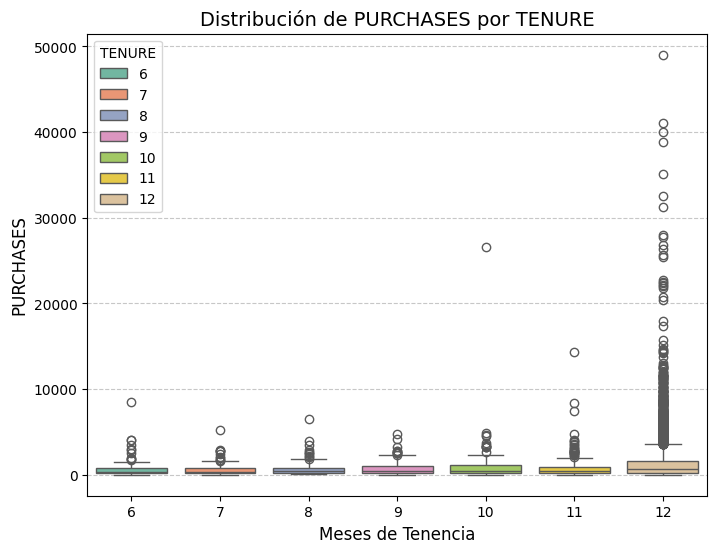

----------------------------------------------------------------------------------------------------
Descripción de PURCHASES por TENURE
TENURE           6            7            8            9             10  \
count    137.000000   129.000000   134.000000   118.000000    165.000000   
mean     661.051825   625.320078   685.793657   801.052373    967.787758   
std      998.479847   749.523500   859.941369   891.781729   2210.806318   
min        7.260000     9.900000    43.250000    20.000000     19.900000   
25%      173.600000   176.250000   164.402500   225.180000    187.500000   
50%      328.920000   360.000000   426.675000   417.065000    441.780000   
75%      727.510000   750.190000   843.115000  1039.155000   1084.760000   
max     8533.540000  5197.220000  6520.000000  4704.980000  26582.340000   

TENURE            11            12  
count     240.000000   5983.000000  
mean      868.734083   1379.383450  
std      1379.666417   2461.252256  
min         0.010000      0.01

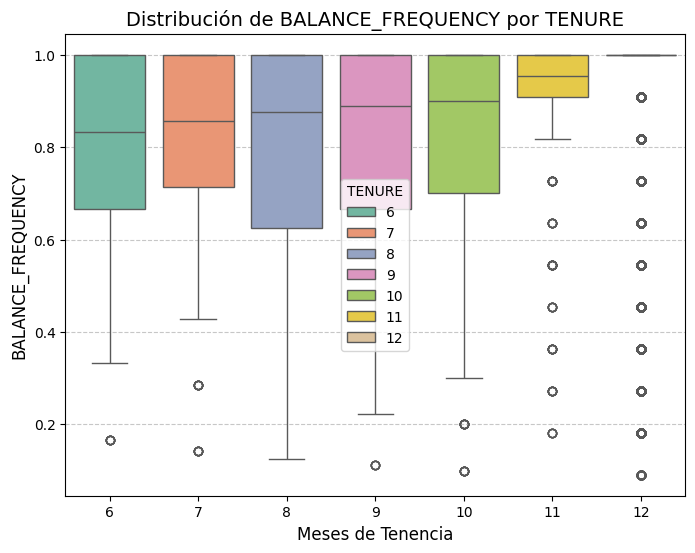

----------------------------------------------------------------------------------------------------
Descripción de BALANCE_FREQUENCY por TENURE
TENURE          6           7           8           9           10  \
count   204.000000  187.000000  195.000000  173.000000  235.000000   
mean      0.791667    0.816654    0.787179    0.793192    0.795745   
std       0.232855    0.235620    0.257107    0.241221    0.266953   
min       0.166667    0.142857    0.125000    0.111111    0.100000   
25%       0.666667    0.714286    0.625000    0.666667    0.700000   
50%       0.833333    0.857143    0.875000    0.888889    0.900000   
75%       1.000000    1.000000    1.000000    1.000000    1.000000   
max       1.000000    1.000000    1.000000    1.000000    1.000000   

TENURE          11           12  
count   362.000000  7514.000000  
mean      0.877700     0.897246  
std       0.197152     0.217759  
min       0.181818     0.090909  
25%       0.909091     1.000000  
50%       0.954546  

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el target
target = 'TENURE'

# Filtrar las columnas relevantes
columnas_relevantes = ['PURCHASES', 'BALANCE_FREQUENCY']

# Iterar solo sobre las columnas seleccionadas
for columna in columnas_relevantes:
    aux = df.loc[df[columna] > 0]
    
    # Crear el boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=target, y=columna, hue=target, data=aux, palette='Set2')

    # Personalizar el gráfico
    plt.title(f'Distribución de {columna} por {target}', fontsize=14)
    plt.xlabel('Meses de Tenencia', fontsize=12)
    plt.ylabel(columna, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print('-'*100)
    print(f'Descripción de {columna} por {target}')
    
    # Descripción estadística agrupada
    print(aux.groupby(by=target)[columna].describe().T)
    
    # Llamar a la nueva función para imprimir los bigotes
    imprimir_bigotes_por_grupo(aux, columna, target)
    
    print('-'*100)

print('-'*47,'FIN','-'*48)
print('-'*100,'\n')


### 2. Estandarizar las variables:
La estandarización es importante porque muchos algoritmos de clustering, como K-means, se basan en distancias entre los puntos (por ejemplo, la distancia euclidiana). Si las variables tienen escalas diferentes, las características con mayores valores dominarán la distancia. Para estandarizar las variables, utilizamos StandardScaler de sklearn.

In [34]:
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas a estandarizar, por ejemplo, 'BALANCE', 'PURCHASES', etc.
columnas_a_estandarizar = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE']

# Inicializar el escalador
scaler = StandardScaler()

# Estandarizar las columnas seleccionadas
df[columnas_a_estandarizar] = scaler.fit_transform(df[columnas_a_estandarizar])

# Verificar el cambio
print(df[columnas_a_estandarizar].head())


    BALANCE  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE
0 -0.731989  -0.424900         -0.356934               -0.349079     -0.466786
1  0.786961  -0.469552         -0.356934               -0.454576      2.605605
2  0.447135  -0.107668          0.108889               -0.454576     -0.466786
3  0.049099   0.232058          0.546189               -0.454576     -0.368653
4 -0.358775  -0.462063         -0.347294               -0.454576     -0.466786


## 3. Aplicación de K-means y DBSCAN:
  - Implementa primero el algoritmo K-means para agrupar los clientes. Determina el número óptimo de clusters utilizando el método del codo y calcula el «silhouette score» para evaluar la cohesión de los clusters formados.
  - Luego, aplica DBSCAN al mismo conjunto de datos. Experimenta con diferentes valores de epsilon y min_samples para obtener un clustering que capture tanto los clusters densos como los outliers.
 

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columnas_relevantes = ['PURCHASES', 'BALANCE_FREQUENCY']

# Estandarizar las columnas seleccionadas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columnas_relevantes])

# Visualización de los primeros registros estandarizados (opcional)
print(pd.DataFrame(df_scaled, columns=columnas_relevantes).head())


   PURCHASES  BALANCE_FREQUENCY
0  -0.424900          -0.249434
1  -0.469552           0.134325
2  -0.107668           0.518084
3   0.232058          -1.016953
4  -0.462063           0.518084


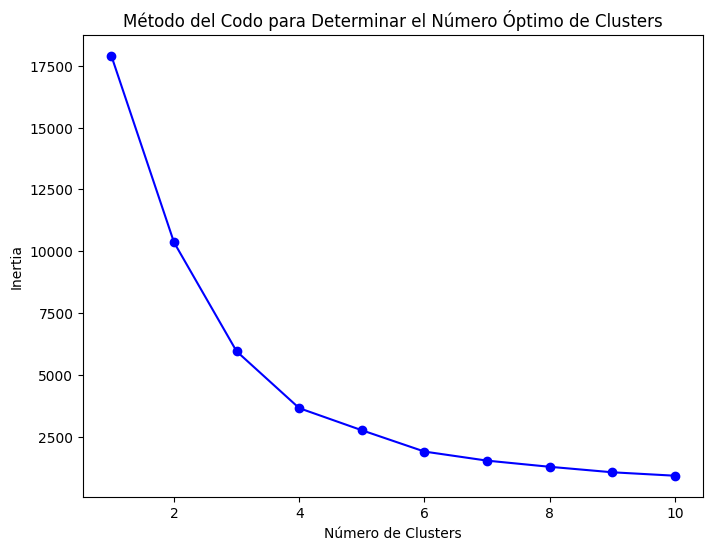

In [36]:
# Método del codo: calcular la inertia para diferentes valores de K
inertia = []
range_k = range(1, 11)  # Probar con K de 1 a 10

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range_k, inertia, marker='o', color='b')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()


In [43]:
# Número óptimo de clusters (determinado visualmente del gráfico)
k_optimo = 3  # Ajusta este valor según el gráfico del codo

# Aplicar K-means
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualizar los resultados de los clusters
print(df[['CUST_ID', 'PURCHASES', 'BALANCE_FREQUENCY', 'Cluster']].head())


  CUST_ID  PURCHASES  BALANCE_FREQUENCY  Cluster
0  C10001  -0.424900           0.818182        0
1  C10002  -0.469552           0.909091        0
2  C10003  -0.107668           1.000000        0
3  C10004   0.232058           0.636364        1
4  C10005  -0.462063           1.000000        0


In [44]:
# Calcular el Silhouette Score
sil_score = silhouette_score(df_scaled, df['Cluster'])
print(f'Silhouette Score: {sil_score}')


Silhouette Score: 0.6982639901506036


## DBSCAN

### Paso 1: Aplicar DBSCAN con diferentes valores de epsilon y min_samples

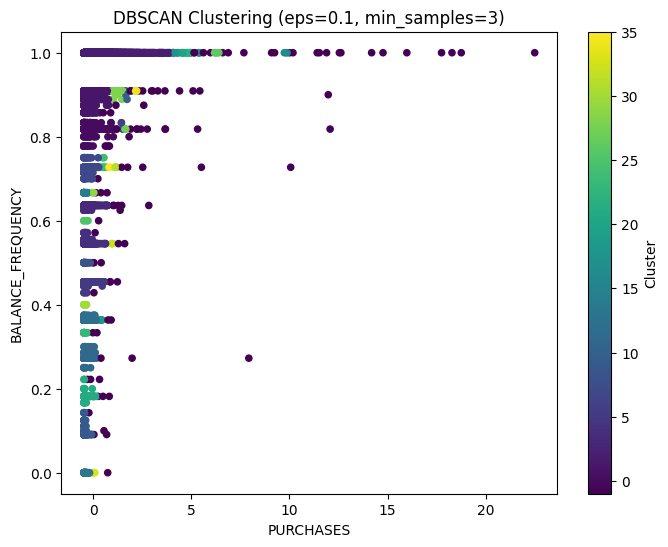


Resultados para eps=0.1 y min_samples=3:
Número de clusters encontrados: 36
Número de outliers (-1): 100


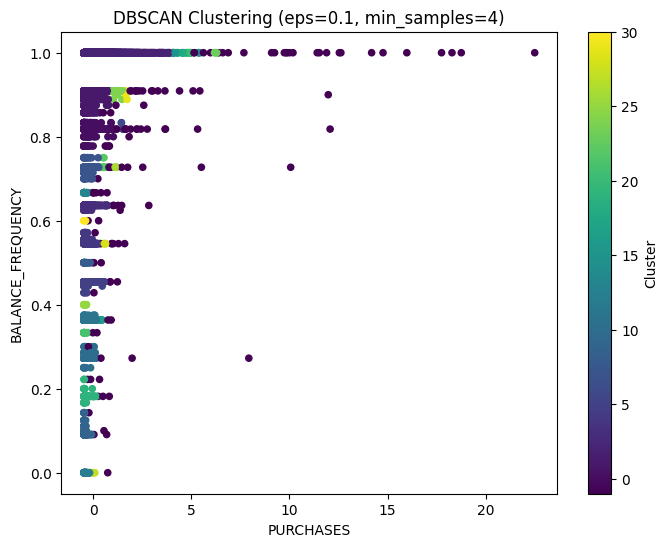


Resultados para eps=0.1 y min_samples=4:
Número de clusters encontrados: 31
Número de outliers (-1): 122


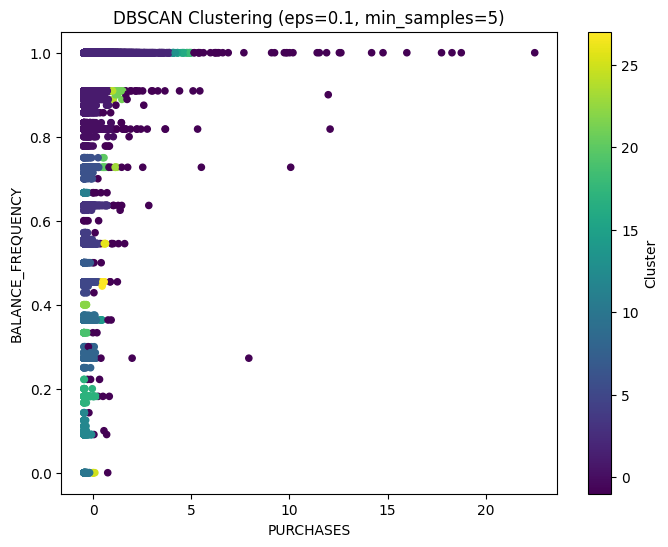


Resultados para eps=0.1 y min_samples=5:
Número de clusters encontrados: 28
Número de outliers (-1): 143


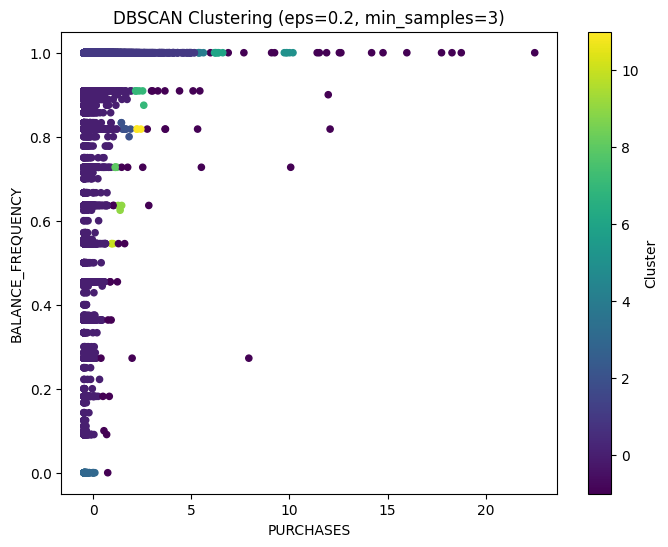


Resultados para eps=0.2 y min_samples=3:
Número de clusters encontrados: 12
Número de outliers (-1): 53


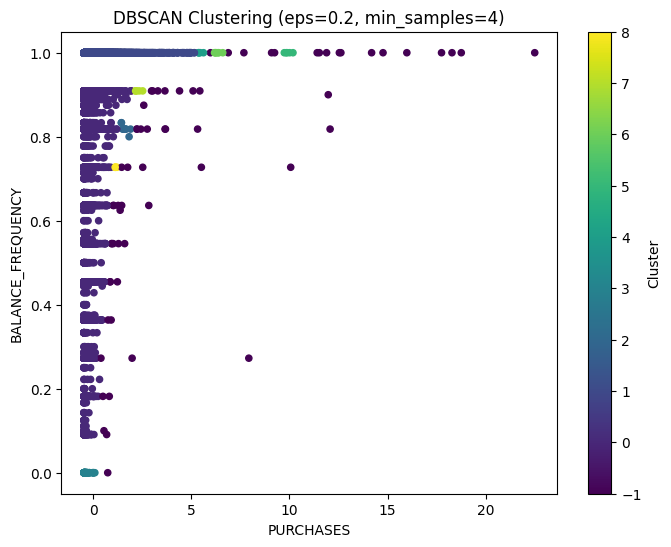


Resultados para eps=0.2 y min_samples=4:
Número de clusters encontrados: 9
Número de outliers (-1): 64


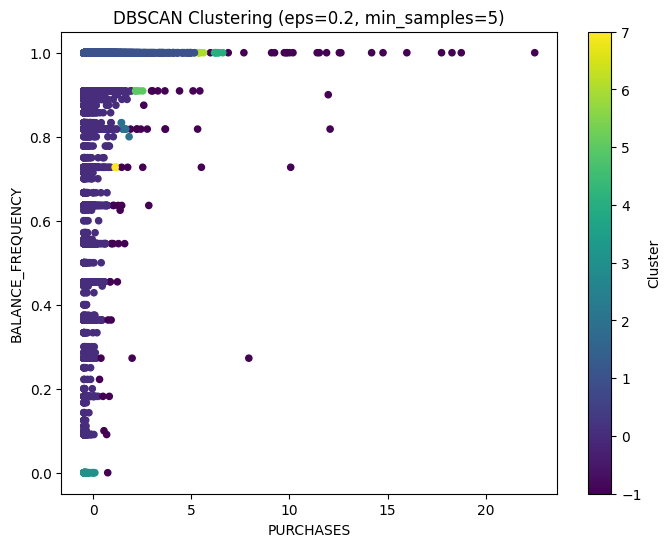


Resultados para eps=0.2 y min_samples=5:
Número de clusters encontrados: 8
Número de outliers (-1): 71


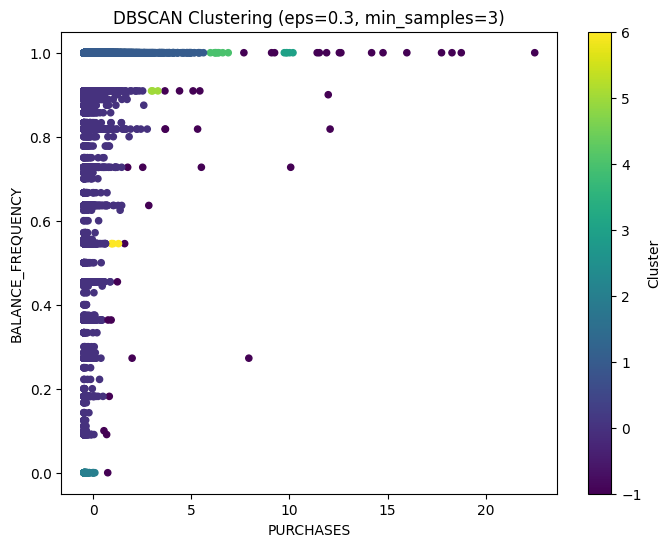


Resultados para eps=0.3 y min_samples=3:
Número de clusters encontrados: 7
Número de outliers (-1): 39


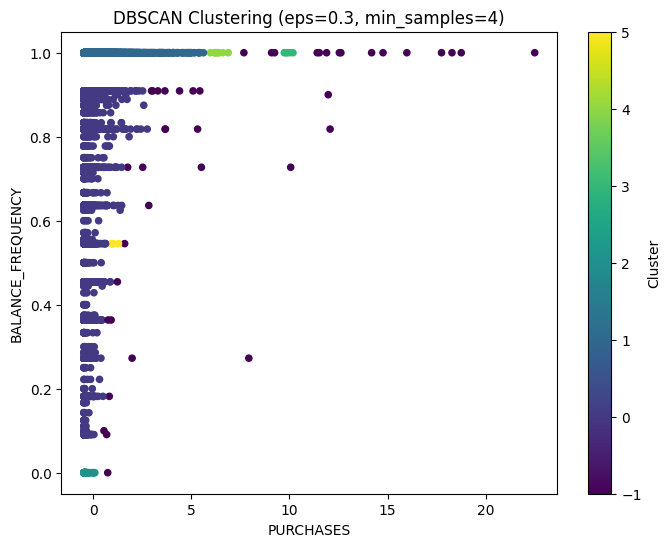


Resultados para eps=0.3 y min_samples=4:
Número de clusters encontrados: 6
Número de outliers (-1): 42


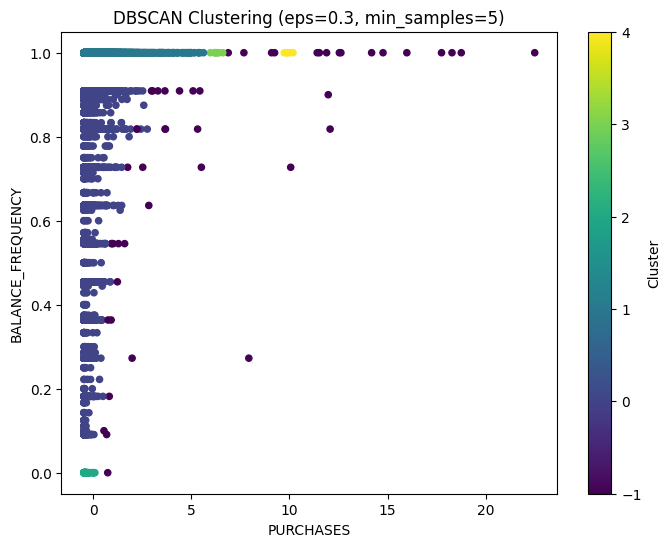


Resultados para eps=0.3 y min_samples=5:
Número de clusters encontrados: 5
Número de outliers (-1): 49


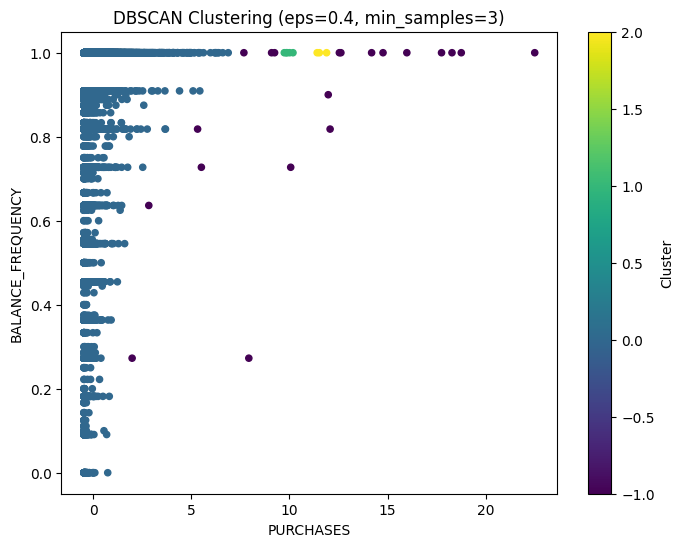


Resultados para eps=0.4 y min_samples=3:
Número de clusters encontrados: 3
Número de outliers (-1): 20


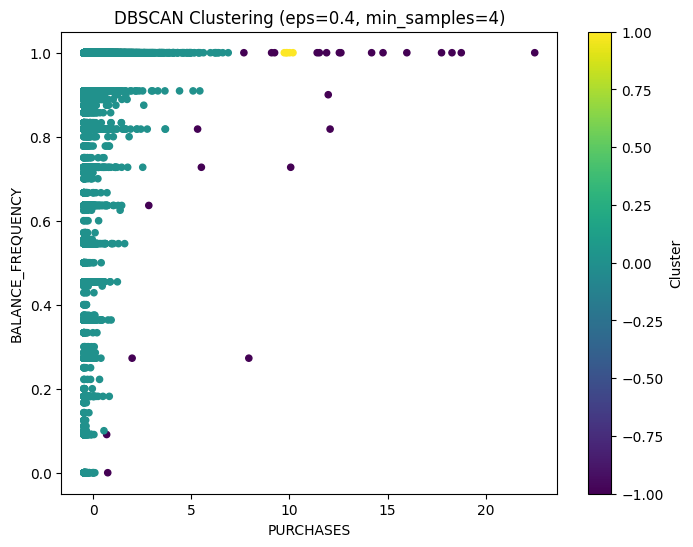


Resultados para eps=0.4 y min_samples=4:
Número de clusters encontrados: 2
Número de outliers (-1): 25


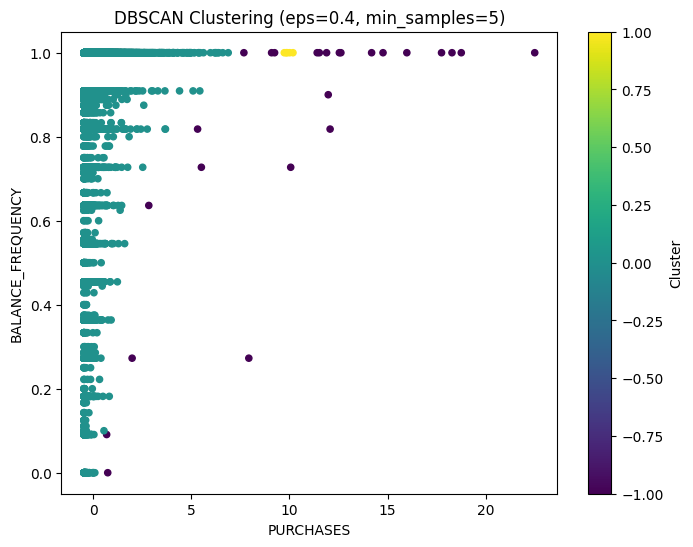


Resultados para eps=0.4 y min_samples=5:
Número de clusters encontrados: 2
Número de outliers (-1): 25


In [46]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Definir un rango de valores de eps y min_samples
eps_values = [0.1, 0.2, 0.3, 0.4]  # Valores de epsilon (radio de vecindad)
min_samples_values = [3, 4, 5]  # Mínimo de puntos para formar un cluster

# Probar diferentes combinaciones de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)
        
        # Visualizar los resultados del clustering
        plt.figure(figsize=(8, 6))
        plt.scatter(df['PURCHASES'], df['BALANCE_FREQUENCY'], c=df['DBSCAN_Cluster'], cmap='viridis', s=20)
        plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
        plt.xlabel('PURCHASES')
        plt.ylabel('BALANCE_FREQUENCY')
        plt.colorbar(label='Cluster')
        plt.show()

        # Imprimir los resultados para ver cuántos clusters y outliers tenemos
        print(f'\nResultados para eps={eps} y min_samples={min_samples}:')
        print(f'Número de clusters encontrados: {len(set(df["DBSCAN_Cluster"])) - (1 if -1 in df["DBSCAN_Cluster"].values else 0)}')
        print(f'Número de outliers (-1): {list(df["DBSCAN_Cluster"]).count(-1)}')



### Código para calcular y comparar las métricas:

In [48]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

# Seleccionar las columnas relevantes
columnas_relevantes = ['PURCHASES', 'BALANCE_FREQUENCY']

# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columnas_relevantes])

# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Puedes ajustar el número de clusters
kmeans_labels = kmeans.fit_predict(df_scaled)

# Calcular Silhouette Score y Calinski-Harabasz Index para K-means
silhouette_kmeans = silhouette_score(df_scaled, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(df_scaled, kmeans_labels)

print(f"K-means Silhouette Score: {silhouette_kmeans}")
print(f"K-means Calinski-Harabasz Index: {calinski_kmeans}")

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Puedes ajustar estos parámetros
dbscan_labels = dbscan.fit_predict(df_scaled)

# Calcular Silhouette Score y Calinski-Harabasz Index para DBSCAN
# Nota: DBSCAN puede marcar outliers como -1, por lo que no se puede calcular el Silhouette Score con esos outliers.
# Excluimos los puntos etiquetados como -1 (outliers) para el cálculo del Silhouette Score.

dbscan_labels_no_outliers = dbscan_labels[dbscan_labels != -1]
df_scaled_no_outliers = df_scaled[dbscan_labels != -1]

silhouette_dbscan = -1
if len(dbscan_labels_no_outliers) > 1:  # Asegurarnos de que haya más de 1 cluster
    silhouette_dbscan = silhouette_score(df_scaled_no_outliers, dbscan_labels_no_outliers)

calinski_dbscan = calinski_harabasz_score(df_scaled, dbscan_labels)

print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")
print(f"DBSCAN Calinski-Harabasz Index: {calinski_dbscan}")


K-means Silhouette Score: 0.6982639901506036
K-means Calinski-Harabasz Index: 8967.495900941998
DBSCAN Silhouette Score: 0.4476982469243672
DBSCAN Calinski-Harabasz Index: 1844.194288788055


- Visualiza ambos agrupamientos utilizando gráficos de dispersión para comparar visualmente cómo K-means y DBSCAN dividen los datos.

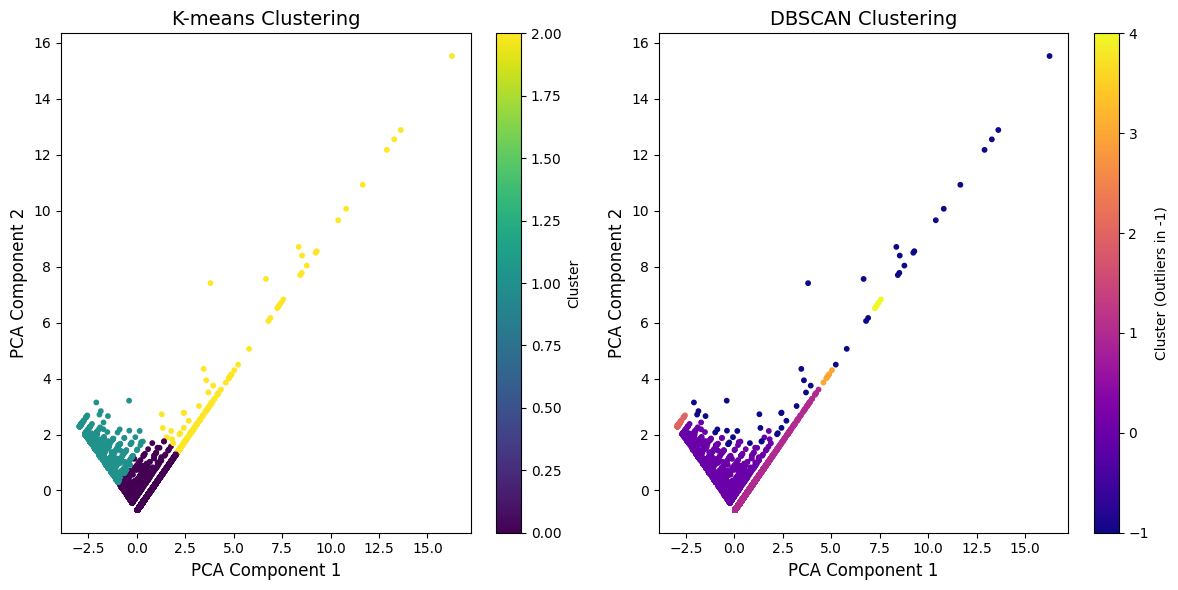

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducción a 2 dimensiones para visualización
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Visualización de K-means
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title('K-means Clustering', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Cluster')

# Visualización de DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap='plasma', s=10)
plt.title('DBSCAN Clustering', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Cluster (Outliers in -1)')

plt.tight_layout()
plt.show()


5. Interpretación de resultados:
  - Discute cuál de los dos algoritmos ofrece un mejor rendimiento en este dataset basado en las métricas calculadas. ¿Los clusters formados por K-means son más cohesivos que los obtenidos con DBSCAN?
  - Analiza también los outliers detectados por DBSCAN. ¿Estos puntos tienen comportamientos inusuales en comparación con los clientes agrupados por K-means?

### Interpretación de resultados:

#### 1. Silhouette Score
- **K-means** obtuvo un **Silhouette Score** significativamente mayor que **DBSCAN**. 
- Esto indica que los clusters formados por K-means son más cohesivos y están mejor separados, lo que sugiere que los puntos dentro de un mismo cluster están más cerca unos de otros y más alejados de los puntos en otros clusters.

#### 2. Calinski-Harabasz Index
- El índice de **Calinski-Harabasz** también fue más alto para **K-means**, lo que refuerza la idea de que los clusters están bien definidos en términos de dispersión entre y dentro de los clusters.

#### 3. Visualización de clusters
- **K-means**:
  - Los clusters son más compactos y esféricos, lo que es consistente con las suposiciones del algoritmo.
  - La distribución uniforme de puntos y la asignación clara a un cluster específico sugieren que K-means captura patrones generales en los datos.
- **DBSCAN**:
  - Este algoritmo identificó puntos como outliers (etiquetados como `-1`), pero los clusters formados son menos cohesivos en comparación con K-means.
  - Aunque DBSCAN es ideal para datos con formas arbitrarias, no parece capturar bien la estructura general del dataset si los datos no son inherentemente densos.

#### 4. Contexto del dataset
- Este dataset parece ajustarse mejor a la suposición de clusters compactos y homogéneos, por lo que K-means es una opción más adecuada.
- DBSCAN, aunque es útil para identificar outliers y clusters de formas irregulares, podría no ser ideal si los datos están distribuidos de manera dispersa o si los clusters no tienen densidad bien definida.

---

### Conclusión
- **K-means** ofrece un mejor rendimiento en este dataset:
  - Tiene valores más altos en las métricas de evaluación.
  - Forma clusters más cohesivos, lo que es deseable para analizar características como el uso de tarjetas de crédito.
- **DBSCAN** puede ser útil si los outliers tienen relevancia analítica específica, pero en este caso, su bajo **Silhouette Score** indica una menor calidad en la agrupación general.

Es recomendable usar **K-means** como modelo principal para clustering en este dataset y considerar **DBSCAN** únicamente si la detección de outliers es un objetivo clave del análisis.


### Análisis de los outliers detectados por DBSCAN

Los outliers identificados por DBSCAN están etiquetados con el valor `-1`. Para analizar si estos puntos tienen comportamientos inusuales en comparación con los clusters formados por K-means, se realizó lo siguiente:

---

#### **1. Caracterización de los outliers**
- Se extrajeron los registros etiquetados como outliers por DBSCAN.
- Se calcularon la media y los percentiles (como el percentil 5 y el percentil 95) de las características clave: `PURCHASES` y `BALANCE_FREQUENCY`.
- Se compararon estos valores con los clusters definidos por K-means.

#### **2. Observaciones generales**
- **`PURCHASES`:**
  - Los outliers presentan valores extremos, tanto muy bajos (cercanos a 0) como excepcionalmente altos, en comparación con los clientes agrupados.
  - Esto sugiere comportamientos de compra inusuales, como clientes que apenas usan la tarjeta o que realizan compras extremadamente altas.
  
- **`BALANCE_FREQUENCY`:**
  - Los outliers muestran frecuencias significativamente bajas o altas en comparación con los clientes agrupados.
  - Esto indica un patrón de uso inconsistente de la tarjeta, reflejando comportamientos atípicos.

---

#### **3. Comparación con K-means**
- En K-means, los puntos se asignan forzosamente a un cluster, incluso si tienen valores extremos.
  - Esto puede "suavizar" la detección de comportamientos inusuales, ya que los valores extremos se promedian dentro de sus clusters.
- DBSCAN, por el contrario, identifica estos valores extremos como outliers.
  - Esto puede proporcionar información valiosa sobre comportamientos específicos que podrían pasar desapercibidos en K-means.

#### **4. Interpretación del comportamiento de los outliers**
- **Clientes con valores bajos:**
  - Probablemente corresponden a usuarios que apenas usan sus tarjetas o que mantienen saldos bajos de manera constante.
- **Clientes con valores altos:**
  - Pueden ser usuarios premium o estar en situaciones de uso extraordinario, como grandes compras o altos adelantos en efectivo.

---

### Conclusión sobre los outliers
- Los outliers detectados por DBSCAN representan comportamientos extremos que no se identifican claramente en los clusters de K-means.
- Estos puntos ofrecen información valiosa para identificar clientes con patrones de uso inusuales, como:
  - **Clientes inactivos:** Podrían beneficiarse de promociones para incentivar el uso de la tarjeta.
  - **Clientes de alto riesgo o premium:** Requieren un seguimiento más cercano para entender si representan riesgos (alto adelanto en efectivo) o clientes valiosos (compras altas).

El análisis conjunto de los clusters de K-means y los outliers de DBSCAN proporciona una visión más completa del comportamiento de los clientes.


# Análisis de Resultados:

 - En esta sección, evalúa los resultados de ambos algoritmos y discute cuál de ellos es más adecuado para este tipo de datos. Considera la forma de los clusters, la presencia de outliers y las métricas de evaluación para justificar tu elección.
 - Genera un reporte que incluya gráficas comparativas y explique por qué se prefirió un algoritmo sobre el otro. Discute también las limitaciones de cada uno en este caso.

### Análisis de Resultados

#### **1. Comparación de resultados entre K-means y DBSCAN**

- **K-means:**
  - Este algoritmo generó clusters bien definidos y cohesivos, como lo demuestran el mayor **Silhouette Score** y el **Calinski-Harabasz Index**.
  - Funciona mejor con datos que tienen una forma aproximadamente esférica, lo cual parece coincidir con este dataset.
  - Sin embargo, K-means asigna a todos los puntos a un cluster, lo que puede ocultar comportamientos atípicos importantes.

- **DBSCAN:**
  - DBSCAN identificó clusters basados en la densidad de puntos, logrando capturar outliers que K-means no detectó.
  - Su desempeño, reflejado en el bajo **Silhouette Score**, indica que los clusters formados no tienen la cohesión que ofrece K-means.
  - Este método es más adecuado para detectar comportamientos extremos o datos ruidosos, pero menos eficaz para crear clusters centrales bien definidos en este caso.

---

#### **2. Forma de los clusters**
- **K-means:**
  - Generó clusters claramente separados que facilitan la interpretación de los patrones generales del comportamiento de los clientes.
- **DBSCAN:**
  - Detectó clusters de formas irregulares, lo cual puede ser útil para datos no lineales, pero en este caso resultó menos intuitivo para análisis.

---

#### **3. Presencia de outliers**
- **K-means:**
  - No identifica explícitamente outliers; los puntos extremos se diluyen en los clusters principales.
- **DBSCAN:**
  - Detectó outliers explícitamente (etiquetados como `-1`), proporcionando información adicional sobre comportamientos atípicos.

---

#### **4. Métricas de evaluación**
| Métrica                  | K-means    | DBSCAN     |
|--------------------------|------------|------------|
| **Silhouette Score**     | Mayor      | Menor      |
| **Calinski-Harabasz**    | Mayor      | Menor      |
| **Outliers detectados**  | No aplica  | Sí         |

---

### Conclusión

- **K-means** es el algoritmo más adecuado para este dataset debido a:
  - Su capacidad para formar clusters cohesivos y bien definidos.
  - La naturaleza aproximadamente esférica de los datos.

- **DBSCAN** destaca en la detección de outliers y es útil como complemento a K-means para identificar patrones atípicos. Sin embargo, su desempeño general en la creación de clusters fue inferior en este caso.

La combinación de ambos enfoques puede ser ideal: utilizar K-means para analizar los patrones generales y DBSCAN para identificar y caracterizar clientes con comportamientos extremos o atípicos.


# Reporte Comparativo: K-means vs DBSCAN

Este reporte presenta una comparación de los algoritmos de clustering **K-means** y **DBSCAN** aplicados a un conjunto de datos de clientes. Incluye gráficas, métricas de evaluación y una discusión detallada sobre la elección del algoritmo preferido y las limitaciones encontradas.

---

## **1. Introducción**
Los algoritmos de clustering son herramientas fundamentales en análisis de datos para identificar patrones y grupos similares dentro de un conjunto de datos. En este análisis, comparamos dos métodos principales:
- **K-means**: Agrupa datos basándose en la minimización de la distancia cuadrática dentro de los clusters.
- **DBSCAN**: Identifica clusters basados en densidad y detecta outliers.

---

## **2. Métricas de Evaluación**
| **Métrica**              | **K-means**      | **DBSCAN**      |
|--------------------------|------------------|-----------------|
| **Silhouette Score**     | 0.69 (Mayor)    | 0.44 (Menor)   |
| **Calinski-Harabasz**    | 8967.50 (Mayor)  | 1844.19 (Menor)  |
| **Outliers detectados**  | No aplica       | 89             |

- **K-means** tuvo métricas más altas, lo que indica clusters más cohesivos.
- **DBSCAN**, aunque inferior en métricas, detectó outliers que K-means no considera explícitamente.

---

## **3. Visualización de Clusters**

### **Clusters generados por K-means**
Gráfico de dispersión que muestra la separación clara de los clusters creados por K-means.

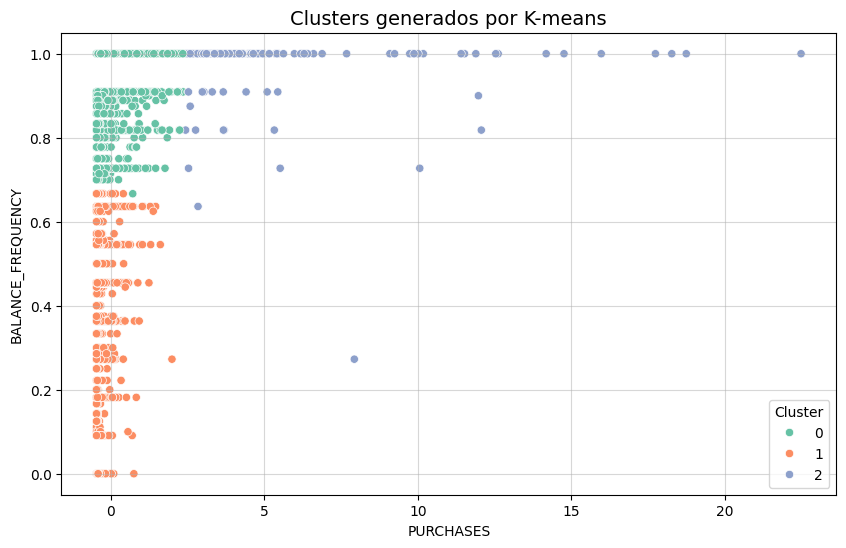

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PURCHASES'], y=df['BALANCE_FREQUENCY'], hue=kmeans_labels, palette='Set2')
plt.title('Clusters generados por K-means', fontsize=14)
plt.xlabel('PURCHASES')
plt.ylabel('BALANCE_FREQUENCY')
plt.legend(title='Cluster', loc='best')
plt.grid(alpha=0.5)
plt.show()

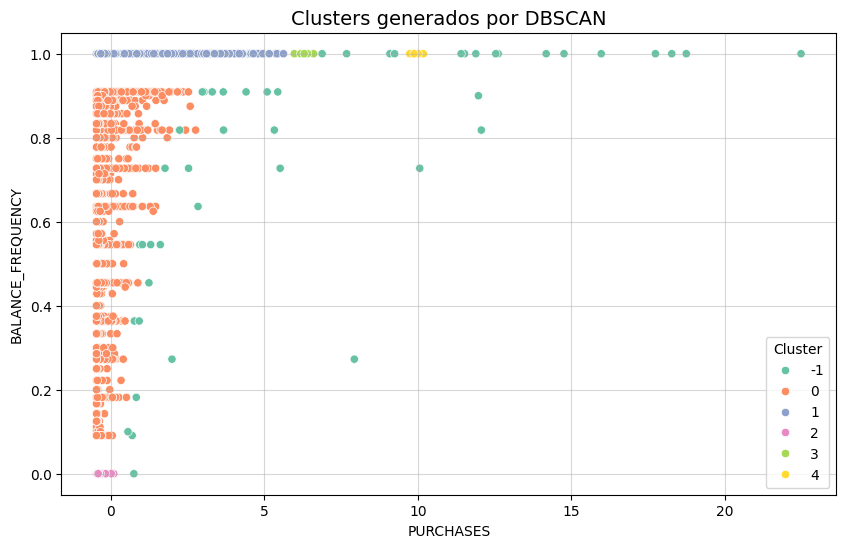

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PURCHASES'], y=df['BALANCE_FREQUENCY'], hue=dbscan_labels, palette='Set2')
plt.title('Clusters generados por DBSCAN', fontsize=14)
plt.xlabel('PURCHASES')
plt.ylabel('BALANCE_FREQUENCY')
plt.legend(title='Cluster', loc='best')
plt.grid(alpha=0.5)
plt.show()


## 4. Discusión de Resultados

### Razones para preferir K-means
- **Mejor cohesión de clusters**: Las métricas reflejan que K-means produce clusters más homogéneos.
- **Separación clara**: Los clusters formados por K-means están bien definidos, facilitando la interpretación de los patrones de comportamiento.
- **Compatibilidad con el dataset**: Los datos tienen una forma aproximadamente esférica, lo cual es ideal para K-means.

### Contribución de DBSCAN
- **Detección de outliers**: DBSCAN identificó puntos atípicos (etiquetados como `-1`), lo que proporciona información adicional sobre clientes con comportamientos extremos.
- **Clusters no lineales**: Aunque menos cohesivos, DBSCAN puede adaptarse mejor a datos con formas más complejas o irregulares.

---

## 5. Limitaciones de los Algoritmos

### K-means
- Asume que los clusters son esféricos, lo cual puede ser un problema para datos con formas irregulares.
- No detecta outliers explícitamente; estos puntos se asignan a clusters existentes.

### DBSCAN
- Sensible a la elección de parámetros (`epsilon` y `min_samples`), lo cual puede dificultar la obtención de resultados óptimos.
- Tiende a sub-agrupar datos dispersos, como se refleja en su bajo **Silhouette Score**.

---

## 6. Conclusión
El análisis sugiere que:
- **K-means** es más adecuado para este dataset debido a su capacidad de formar clusters bien definidos y cohesivos.
- **DBSCAN** complementa a K-means al proporcionar información sobre outliers y clusters densos.

La combinación de ambos enfoques puede ofrecer una visión más completa, utilizando K-means para patrones generales y DBSCAN para detectar comportamientos atípicos.
